In [1]:
import sys
sys.path.insert(1, './imports')
import pandas as pd
import numpy as np
from exploratory_analysis import *
from preprocessing import *
from model_selection import *
from model_end_to_end import *
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

In [2]:
fires = pd.read_csv("fires.csv")

# Estimation of the average absolute loss in hA

## Model with preclassification and split of the data

In [3]:
msinho_acc = MontesinhoCompleteModel_evaluator(SVC(kernel = 'rbf', gamma=0.002652859881404326, C= 100, degree=5),
                                           SVC(C=8.41850316809234, gamma=0.04349773501643578, kernel='linear'),
                                           SVC(C=0.26869573356106563, degree=2, gamma=0.9600363819999834, kernel='poly'),
                                           PolynomialFeatures(degree=3),
                                           PolynomialFeatures(degree=1),
                                           PolynomialFeatures(degree=3),
                                           GradientBoostingRegressor(learning_rate= 0.1875, n_estimators= 20),
                                           GradientBoostingRegressor(learning_rate= 0.46, n_estimators= 20),
                                           GradientBoostingRegressor(learning_rate= 0.6, n_estimators= 20))
msinho_acc.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(msinho_acc.average_loss()) - 1)

average absolute loss per instance, in hA:  2.70763448575178


## Random Forest Regressor with hyperparameter tuning

In [4]:
montesinho_rfr = MontesinhoCompleteModel_evaluator_simple(RandomForestRegressor(criterion = "mse", n_estimators= 100), 1)
montesinho_rfr.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(montesinho_rfr.evaluate()) - 1)
montesinho_rfr.train()

average absolute loss per instance, in hA:  2.256564260339103


## Gradient Boosting Regressor with hyperparameter tuning

In [5]:
montesinho_gbr = MontesinhoCompleteModel_evaluator_simple(GradientBoostingRegressor(learning_rate= 0.05, n_estimators= 100), 1)
montesinho_gbr.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(montesinho_gbr.evaluate()) - 1)
montesinho_gbr.train()

average absolute loss per instance, in hA:  2.216605048066975


## Gradient Boosting Regressor with feature engineering

In [6]:
features_removed = ['apr_bool', '66', '73', '65', '74', '64', '75', '95', '63', '99', '84', '55', '13', 'aug_bool', '76', '43', '44', '85', 'rain', '94', 'oct_bool', '45', '33', 'nov_bool', 'feb_bool', '23',
 'wed', 'mar_bool', 'fri', 'jun_bool', '14', 'tue', '24', '88', '46', 'sat']
features_added = [["22","sat"], ["wed","pc5"], ["tue","pc2"], ["94", "pc6"], ['sep_bool','pc4']]
montesinho_gbr_fe = MontesinhoCompleteModel_evaluator_fe(GradientBoostingRegressor(learning_rate= 0.05, n_estimators= 100), 1, features_added, features_removed)
montesinho_gbr_fe.fit(fires)
print("average absolute loss per instance, in hA: ", np.exp(montesinho_gbr_fe.evaluate()) - 1)
montesinho_gbr_fe.train()
#montesinho_gbr_fe.save_model("model_gbr_re.pickle")

average absolute loss per instance, in hA:  2.029817016475741


# Model piecewise behaviour for the three simple models
Now, even if it's goinf to depend highly on chance, let's try to observe how the model works depending on the value of the target variable

In [7]:
indexes_0 = fires[fires["area"] == 0].sample(25, random_state=3558).index
indexes_0_10 = fires[(fires["area"] != 0) & (fires["area"] <= 10)].sample(20, random_state=3558).index
indexes_10_40 = fires[(fires["area"] <= 40) & (fires["area"] > 10)].sample(20, random_state=3558).index
indexes_40_plus = fires[(fires["area"] > 40)].sample(10, random_state=3558).index
evaluation_indexes = [*indexes_0, *indexes_0_10, *indexes_10_40, *indexes_40_plus]
train_indexes = np.array([i for i in np.arange(0, fires.shape[0]-1) if i not in evaluation_indexes])
data_train = fires.iloc[train_indexes]
data_evaluation = fires.iloc[evaluation_indexes]

## Random Forest Regressor with hyperparameter tuning

In [8]:
montesinho_rfr.fit(data_train)
montesinho_rfr.train()
df_0_rfr = pd.DataFrame(columns =["obs", "pred"])
df_0_10_rfr = pd.DataFrame(columns =["obs", "pred"])
df_10_40_rfr = pd.DataFrame(columns =["obs", "pred"])
df_40_plus_rfr = pd.DataFrame(columns =["obs", "pred"])
for i in indexes_0:
    df_0_rfr = df_0_rfr.append({"obs":fires["area"].iloc[i], "pred":montesinho_rfr.predict_instance(fires.iloc[i])}, ignore_index=True)
for i in indexes_0_10:
    df_0_10_rfr = df_0_10_rfr.append({"obs":fires["area"].iloc[i], "pred":montesinho_rfr.predict_instance(fires.iloc[i])}, ignore_index=True)
for i in indexes_10_40:
    df_10_40_rfr = df_10_40_rfr.append({"obs":fires["area"].iloc[i], "pred":montesinho_rfr.predict_instance(fires.iloc[i])}, ignore_index=True)
for i in indexes_40_plus:
    df_40_plus_rfr = df_40_plus_rfr.append({"obs":fires["area"].iloc[i], "pred":montesinho_rfr.predict_instance(fires.iloc[i])}, ignore_index=True)

## Gradient Boosting Regressor with hyperparameter tuning

In [9]:
montesinho_gbr.fit(fires)
montesinho_gbr.train()
df_0_gbr = pd.DataFrame(columns =["obs", "pred"])
df_0_10_gbr = pd.DataFrame(columns =["obs", "pred"])
df_10_40_gbr = pd.DataFrame(columns =["obs", "pred"])
df_40_plus_gbr = pd.DataFrame(columns =["obs", "pred"])
for i in indexes_0:
    df_0_gbr = df_0_gbr.append({"obs":fires["area"].iloc[i], "pred":montesinho_gbr.predict_instance(fires.iloc[i])}, ignore_index=True)
for i in indexes_0_10:
    df_0_10_gbr = df_0_10_gbr.append({"obs":fires["area"].iloc[i], "pred":montesinho_gbr.predict_instance(fires.iloc[i])}, ignore_index=True)
for i in indexes_10_40:
    df_10_40_gbr = df_10_40_gbr.append({"obs":fires["area"].iloc[i], "pred":montesinho_gbr.predict_instance(fires.iloc[i])}, ignore_index=True)
for i in indexes_40_plus:
    df_40_plus_gbr = df_40_plus_gbr.append({"obs":fires["area"].iloc[i], "pred":montesinho_gbr.predict_instance(fires.iloc[i])}, ignore_index=True)

## Gradient Boosting Regressor with feature engineering

In [10]:
montesinho_gbr_fe.fit(fires)
montesinho_gbr_fe.train()
df_0_gbr_fe = pd.DataFrame(columns =["obs", "pred"])
df_0_10_gbr_fe = pd.DataFrame(columns =["obs", "pred"])
df_10_40_gbr_fe = pd.DataFrame(columns =["obs", "pred"])
df_40_plus_gbr_fe = pd.DataFrame(columns =["obs", "pred"])
for i in indexes_0:
    df_0_gbr_fe = df_0_gbr_fe.append({"obs":fires["area"].iloc[i], "pred":montesinho_gbr_fe.predict_instance(fires.iloc[i])}, ignore_index=True)
for i in indexes_0_10:
    df_0_10_gbr_fe = df_0_10_gbr_fe.append({"obs":fires["area"].iloc[i], "pred":montesinho_gbr_fe.predict_instance(fires.iloc[i])}, ignore_index=True)
for i in indexes_10_40:
    df_10_40_gbr_fe = df_10_40_gbr_fe.append({"obs":fires["area"].iloc[i], "pred":montesinho_gbr_fe.predict_instance(fires.iloc[i])}, ignore_index=True)
for i in indexes_40_plus:
    df_40_plus_gbr_fe = df_40_plus_gbr_fe.append({"obs":fires["area"].iloc[i], "pred":montesinho_gbr_fe.predict_instance(fires.iloc[i])}, ignore_index=True)

### Visual comparaison

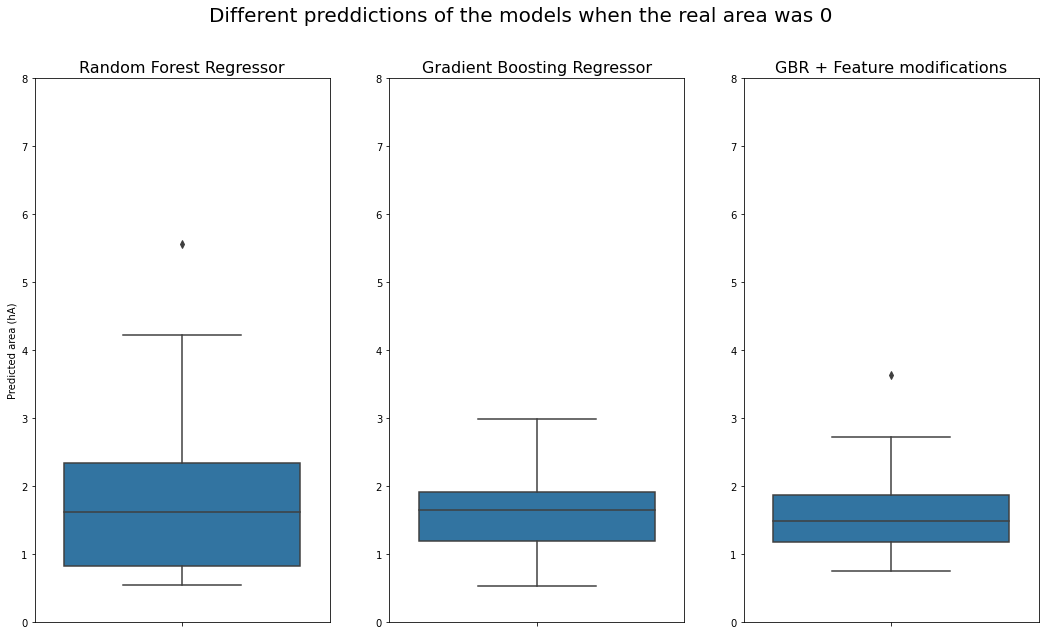

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10))
fig.suptitle("Different preddictions of the models when the real area was 0", fontsize=20)
g1 = sns.boxplot(y = "pred", data=df_0_rfr, ax=ax1)
g1.set_ylim([0, 8])
g1.set_ylabel("Predicted area (hA)")
g1.set_title("Random Forest Regressor", fontsize=16)
g2 = sns.boxplot(y = "pred", data=df_0_gbr, ax=ax2)
g2.set_ylim([0, 8])
g2.set_ylabel("")
g3 = sns.boxplot(y = "pred", data=df_0_gbr_fe, ax=ax3)
g3.set_ylim([0, 8])
g2.set_title("Gradient Boosting Regressor", fontsize=16)
g3.set_ylabel("")
g3.set_title("GBR + Feature modifications", fontsize=16)
plt.show()

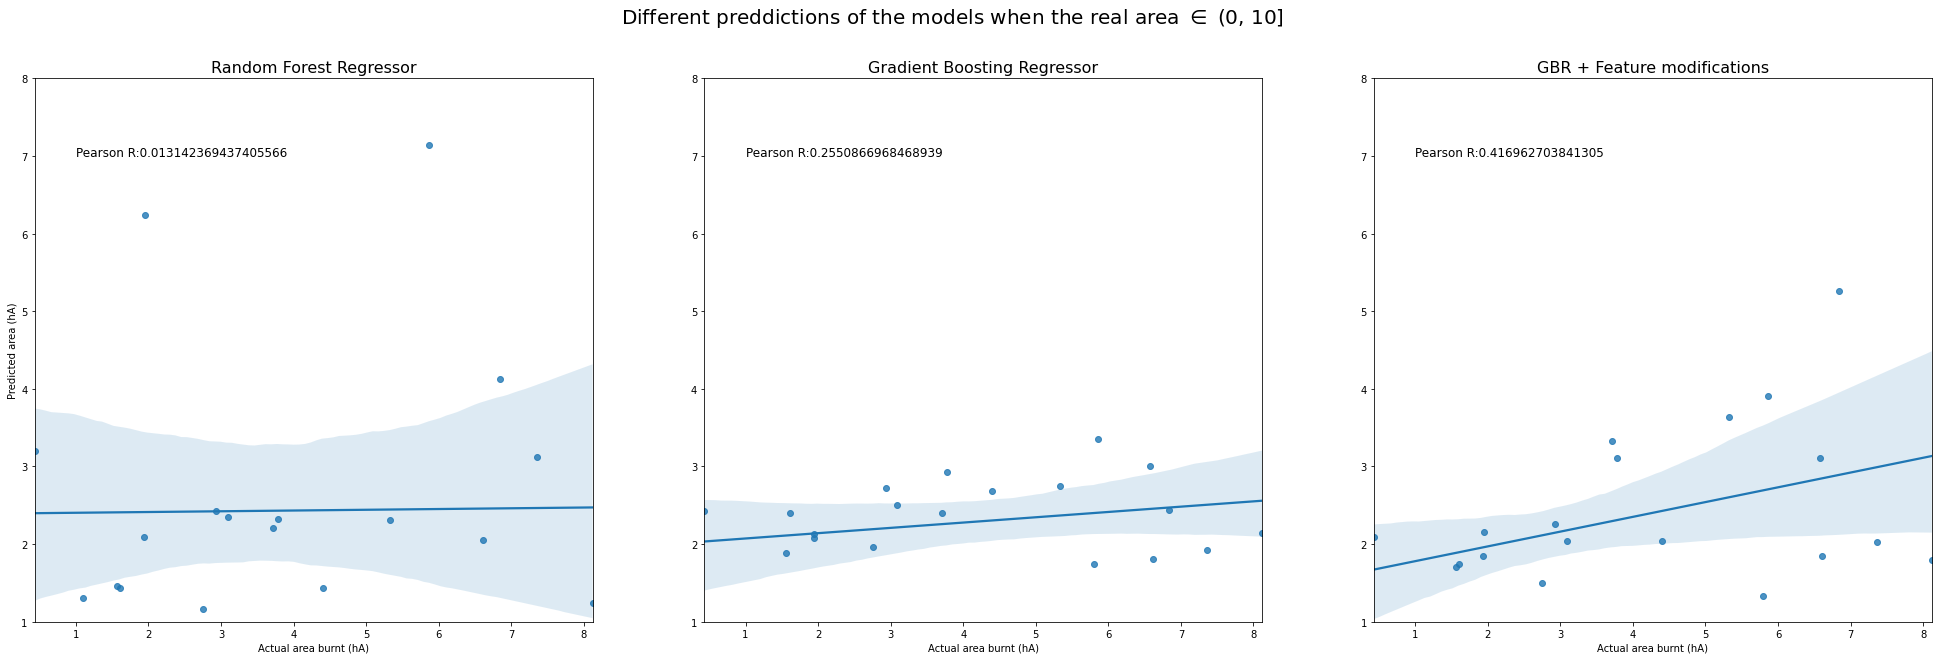

In [12]:
from scipy.stats import pearsonr
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(34, 10))
fig.suptitle("Different preddictions of the models when the real area $\in$ (0, 10]", fontsize=20)
g1 = sns.regplot(y = "pred", x="obs", data=df_0_10_rfr, ax=ax1)
g1.set_ylim([1, 8])
ax1.text(1, 7, "Pearson R:{}".format(pearsonr(df_0_10_rfr["obs"], df_0_10_rfr["pred"])[0]), fontsize=12)
g1.set_ylabel("Predicted area (hA)")
g1.set_title("Random Forest Regressor", fontsize=16)
g2 = sns.regplot(y = "pred", x="obs", data=df_0_10_gbr, ax=ax2)
g2.set_ylim([1, 8])
ax2.text(1, 7, "Pearson R:{}".format(pearsonr(df_0_10_gbr["obs"], df_0_10_gbr["pred"])[0]), fontsize=12)
g2.set_ylabel("")
g3 = sns.regplot(y = "pred", x="obs", data=df_0_10_gbr_fe, ax=ax3)
g3.set_ylim([1, 8])
ax3.text(1, 7, "Pearson R:{}".format(pearsonr(df_0_10_gbr_fe["obs"], df_0_10_gbr_fe["pred"])[0]), fontsize=12)
g2.set_title("Gradient Boosting Regressor", fontsize=16)
g3.set_ylabel("")
g3.set_title("GBR + Feature modifications", fontsize=16)
g1.set_xlabel("Actual area burnt (hA)")
g2.set_xlabel("Actual area burnt (hA)")
g3.set_xlabel("Actual area burnt (hA)")
plt.show()

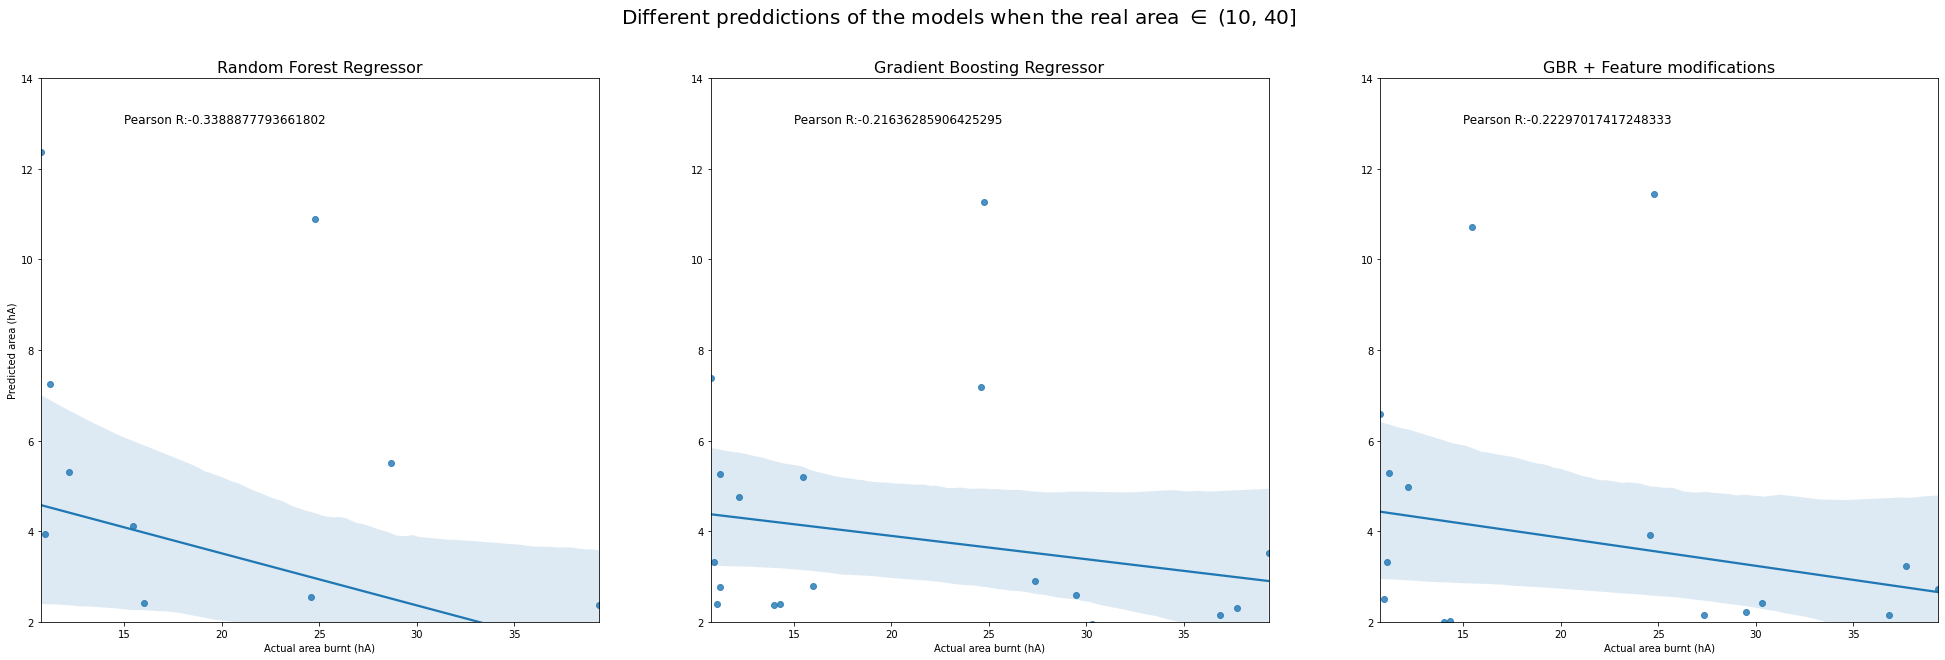

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(34, 10))
fig.suptitle("Different preddictions of the models when the real area $\in$ (10, 40]", fontsize=20)
g1 = sns.regplot(y = "pred", x="obs", data=df_10_40_rfr, ax=ax1)
g1.set_ylim([2, 14])
ax1.text(15, 13, "Pearson R:{}".format(pearsonr(df_10_40_rfr["obs"], df_10_40_rfr["pred"])[0]), fontsize=12)
g1.set_ylabel("Predicted area (hA)")
g1.set_title("Random Forest Regressor", fontsize=16)
g2 = sns.regplot(y = "pred", x="obs", data=df_10_40_gbr, ax=ax2)
g2.set_ylim([2, 14])
ax2.text(15, 13, "Pearson R:{}".format(pearsonr(df_10_40_gbr["obs"], df_10_40_gbr["pred"])[0]), fontsize=12)
g2.set_ylabel("")
g3 = sns.regplot(y = "pred", x="obs", data=df_10_40_gbr_fe, ax=ax3)
g3.set_ylim([2, 14])
ax3.text(15, 13, "Pearson R:{}".format(pearsonr(df_10_40_gbr_fe["obs"], df_10_40_gbr_fe["pred"])[0]), fontsize=12)
g2.set_title("Gradient Boosting Regressor", fontsize=16)
g3.set_ylabel("")
g3.set_title("GBR + Feature modifications", fontsize=16)
g1.set_xlabel("Actual area burnt (hA)")
g2.set_xlabel("Actual area burnt (hA)")
g3.set_xlabel("Actual area burnt (hA)")
plt.show()

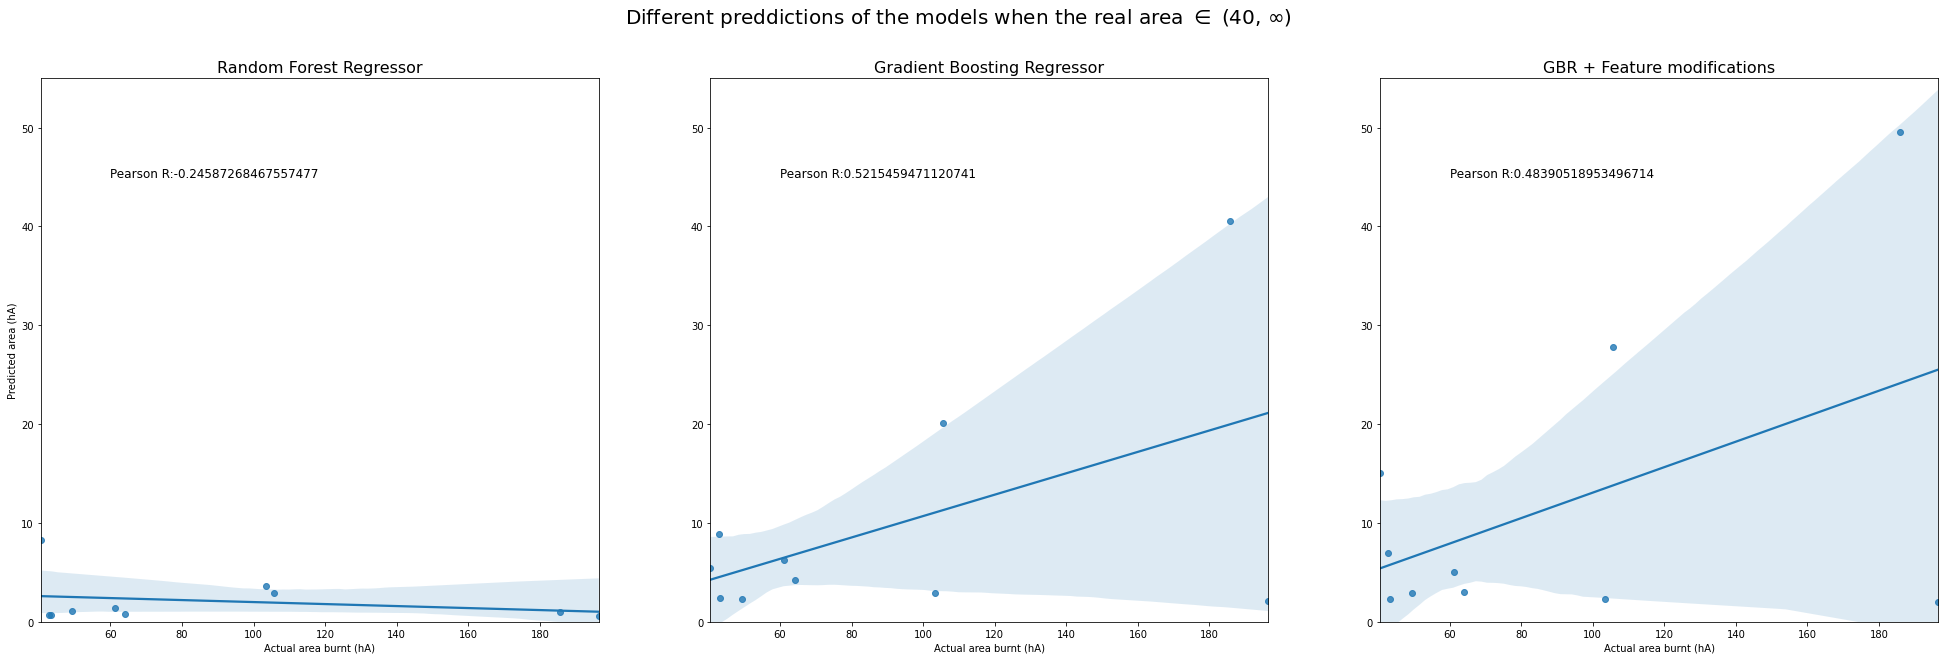

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(34, 10))
fig.suptitle("Different preddictions of the models when the real area $\in$ (40, $\infty$)", fontsize=20)
g1 = sns.regplot(y = "pred", x="obs", data=df_40_plus_rfr, ax=ax1)
g1.set_ylim([0, 55])
ax1.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_rfr["obs"], df_40_plus_rfr["pred"])[0]), fontsize=12)
g1.set_ylabel("Predicted area (hA)")
g1.set_title("Random Forest Regressor", fontsize=16)
g2 = sns.regplot(y = "pred", x="obs", data=df_40_plus_gbr, ax=ax2)
g2.set_ylim([0, 55])
ax2.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_gbr["obs"], df_40_plus_gbr["pred"])[0]), fontsize=12)
g2.set_ylabel("")
g3 = sns.regplot(y = "pred", x="obs", data=df_40_plus_gbr_fe, ax=ax3)
g3.set_ylim([0, 55])
ax3.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_gbr_fe["obs"], df_40_plus_gbr_fe["pred"])[0]), fontsize=12)
g2.set_title("Gradient Boosting Regressor", fontsize=16)
g3.set_ylabel("")
g3.set_title("GBR + Feature modifications", fontsize=16)
g1.set_xlabel("Actual area burnt (hA)")
g2.set_xlabel("Actual area burnt (hA)")
g3.set_xlabel("Actual area burnt (hA)")
plt.show()

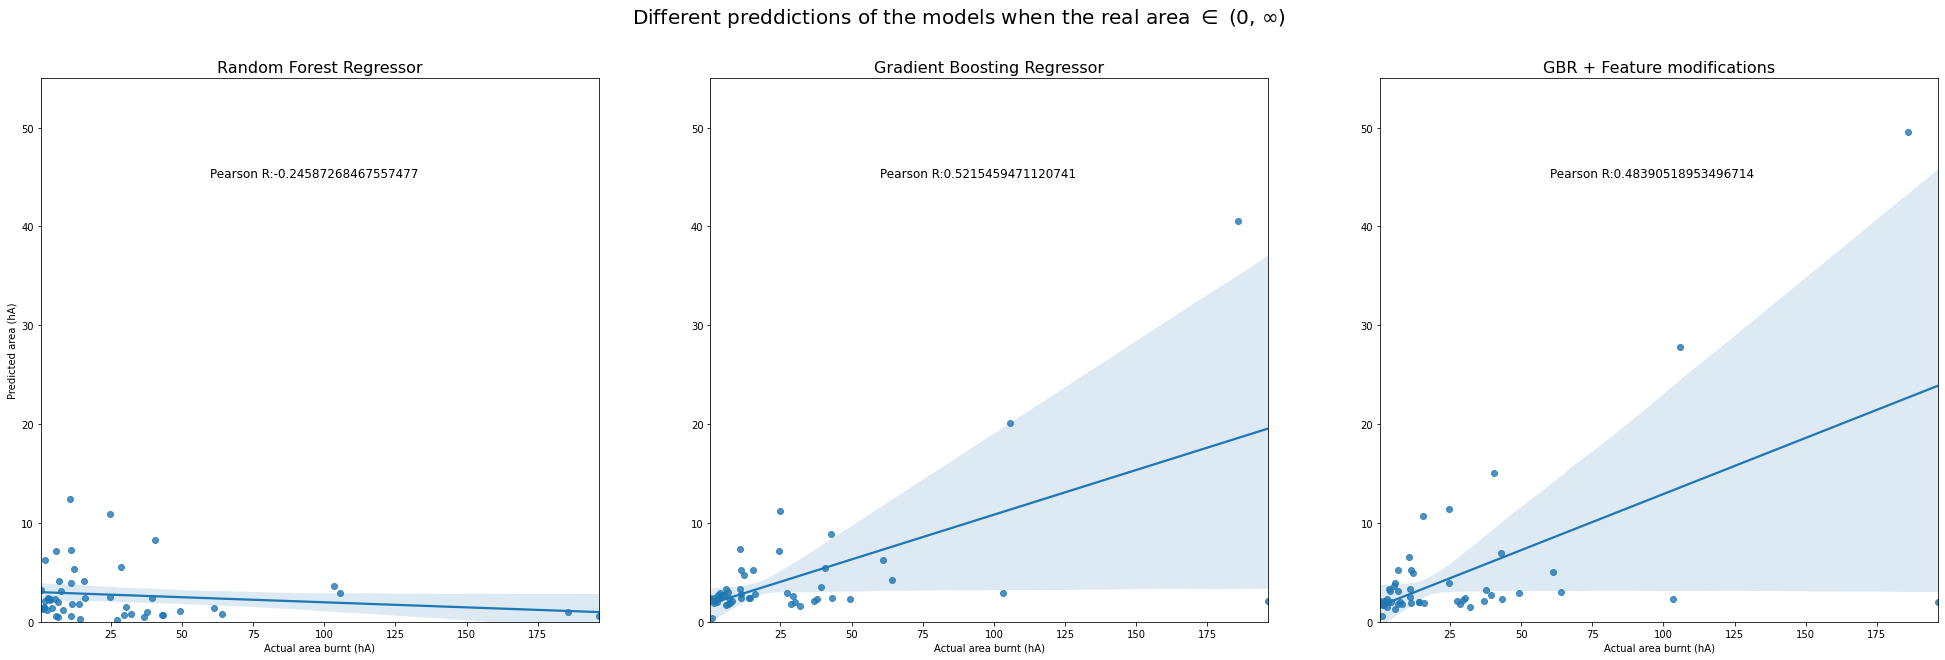

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(34, 10))
fig.suptitle("Different preddictions of the models when the real area $\in$ (0, $\infty$)", fontsize=20)
g1 = sns.regplot(y = "pred", x="obs", data=pd.concat([df_0_10_rfr, df_10_40_rfr, df_40_plus_rfr], axis=0), ax=ax1)
g1.set_ylim([0, 55])
ax1.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_rfr["obs"], df_40_plus_rfr["pred"])[0]), fontsize=12)
g1.set_ylabel("Predicted area (hA)")
g1.set_title("Random Forest Regressor", fontsize=16)
g2 = sns.regplot(y = "pred", x="obs", data=pd.concat([df_0_10_gbr, df_10_40_gbr, df_40_plus_gbr], axis=0), ax=ax2)
g2.set_ylim([0, 55])
ax2.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_gbr["obs"], df_40_plus_gbr["pred"])[0]), fontsize=12)
g2.set_ylabel("")
g3 = sns.regplot(y = "pred", x="obs", data=pd.concat([df_0_10_gbr_fe, df_10_40_gbr_fe, df_40_plus_gbr_fe], axis=0), ax=ax3)
g3.set_ylim([0, 55])
ax3.text(60, 45, "Pearson R:{}".format(pearsonr(df_40_plus_gbr_fe["obs"], df_40_plus_gbr_fe["pred"])[0]), fontsize=12)
g2.set_title("Gradient Boosting Regressor", fontsize=16)
g3.set_ylabel("")
g3.set_title("GBR + Feature modifications", fontsize=16)
g1.set_xlabel("Actual area burnt (hA)")
g2.set_xlabel("Actual area burnt (hA)")
g3.set_xlabel("Actual area burnt (hA)")
plt.show()

In conclussion:

- Even when the difference in average loss was not huge, a huge difference in the models can be observed. This is probably because fires with lower areas burnt are a major fraction of the observations.
- With respect to the mean in the intervals, the models work better where the burnt area is small
- All models are overestimating the fires where the area burnt was 0. This is to expected, due to the use of log-scaling for training the algorithms
- Models 2 and 3 perform (apparently) significantly better in the instances where the area was 0
- For $y \in (0, 10]$ the fine-tuned model performs (apparently) better than the other two models. The RF regressor behaves here very close to random, and the GB regressor without feature engineering is between both.
- There seems to be some instances where the third model yields accurate predictions and others where it behaves randomly. This supports the idea of one or more latent variables that are not captured in the data.
- For $y \in (10, 40]$ both three models have a similar behaviour: Few instances are correctly predicted, the other have even a negative correlation
- $y \in (40, \infty]$ the models 2 and 3 behave similarly, again there are some instances where the predictions are closer to the real value, and others where they are close to the average on the interval. Model 1 doesn't have apparently any predictive power on this interval
- On the interval $y \in (0, \infty]$, models 2 and 3 behave similarly, model 2 apparently has a higher correlation coefficient between the real and predicted values. The random forest regressor seems almost like a blob with no correlation.
- Model 3 and 2 perform better than 1. Model 3 performs better predicting small fires, which correspond to the majority of the training instances. That's the probably the reason why it has a slighly lower average absolute loss.